In [35]:
from numpy import meshgrid, sqrt, diff
from scipy import inf, pi, exp, linspace, zeros, real, imag, array, log
from scipy.stats import norm
from scipy.integrate import quad
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
def der_f(f, x, epsilon=0.001):

    return (f(x + epsilon) - f(x)) / epsilon

def plot_f(f, N, x_min, x_max):

    x_vals = np.linspace(x_min, x_max, N)
    y_vals = []

    for i in x_vals:

        y_vals.append(f(i))

    fig = plt.figure(figsize = (10, 5))
    plt.plot(x_vals, y_vals)

def NewtonRaphson(market_price,
                  S,
                  K,
                  T,
                  r=0,
                  x0=1, cvg_e=.0001, x_min = -5, x_max = 5, N=1000):

    exitCondition = False
    x = x0
    iteration_num = 0

    def f(sigma):
    
        """
        - S: spot price
        - K: strike price
        - T: time to maturity
        - r: interest rate
        - sigma: volatility of underlying asset
        """
    
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
        call = (S * ss.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * ss.norm.cdf(d2, 0.0, 1.0))
    
        return call - market_price
  
    while not exitCondition:

        # Increment iteration number
        iteration_num = iteration_num + 1

        # Calculate the new x value
        x = x - f(x) / der_f(f, x)

        # Exit condition if we are getting away from the zero 
        if abs(f(x)) < cvg_e or iteration_num > 100:
            print('        Newton-Raphson algorithm        ')
            print('        ------------------------        ')
            print(f'- Zero of the function f: {x}')
            print(f'- Number of iteration: {iteration_num}')
            print(f'- Tolerance: {cvg_e}')
            print('        ------------------------        ')
            return x

In [15]:
# -*- coding: utf-8 -*-
from scipy import *
from scipy.integrate import quad

s0=100

#public
def call_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    p1 = __p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K)
    p2 = __p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K)
    return (s0 * p1 - K * exp(-r * T) * p2)

#private
def __p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 , K, status):
    integrand = lambda phi: (exp(-1j * phi * log(K)) * 
    __f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status) / (1j * phi)).real    
    return (0.5 + (1 / pi) * quad(integrand, 0, 100)[0])
def __p1(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    return __p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 1)
def __p2(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    return __p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 2)

def __f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status):
        
    if status == 1:
        u = 0.5
        b = kappa - rho * sigma
    else:
        u = -0.5
        b = kappa
    
    a = kappa * theta
    x = log(s0)
    d = sqrt((rho * sigma * phi * 1j - b)**2 - sigma**2 * (2 * u * phi * 1j - phi**2))
    g = (b - rho * sigma * phi * 1j + d) / (b - rho * sigma * phi * 1j - d)
    C = r * phi * 1j * T + (a / sigma**2)*((b - rho * sigma * phi * 1j + d) * T - 2 * log((1 - g * exp(d * T))/(1 - g)))
    D = (b - rho * sigma * phi * 1j + d) / sigma**2 * ((1 - exp(d * T)) / (1 - g * exp(d * T)))
    return exp(C + D * v0 + 1j * phi * x)

In [119]:
def objective(x):
    
    objective_sum = 0
    maturities = [12/12, 9/12, 6/12, 3/12]
    strikes = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
    market_prices = [[12.40, 9.59 ,8.28, 7.40, 6.86, 6.58 ,6.52 ,6.49 ,6.47, 6.46],
                    [11.79, 8.95, 8.07, 7.03, 6.18, 6.04, 5.76, 5.50, 5.50, 5.39],
                    [10.71, 8.28, 6.91, 6.36, 5.29, 5.07, 4.76, 4.47, 4.35, 4.14],
                    [8.67, 7.14, 5.98, 4.93, 4.09, 3.99, 3.43, 3.01, 2.72, 2.53]]
    
    
    for k in range(len(maturities)):
        
        for i in range(10):

            # Payoff can be obtained with the following line
            call_p = call_price(kappa=x[0], theta=x[1], sigma=x[2], rho=x[3], v0=x[4] ,r=0 ,T=maturities[k] ,s0=100 ,K=strikes[i])

            objective_sum = objective_sum + (call_p - market_prices[k][i]) ** 2
        
    return objective_sum

In [22]:
import sys
import os
from scipy import loadtxt
import numpy as np
from numpy.linalg import norm

#maturity
T = 5.0
#risk free rate
r = 0.05
#long term volatility(equiribrium level)
theta = 0.1
#Mean reversion speed of volatility
kappa = 1.1
#sigma(volatility of Volatility)
sigma = 0.4
#rho
rho = -0.6
#Initial stock price
s0 = 1.0
#Initial volatility
v0 = 0.1

strikes = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
market_prices = [12.40, 9.59 ,8.28, 7.40, 6.86, 6.58 ,6.52 ,6.49 ,6.47, 6.46]
heston_prices = []

for strike in strikes:
    
    heston_prices.append(call_price(kappa, theta, sigma, rho, v0 ,r ,T=1 ,s0=100, K=strike))

In [25]:
optimal_params = [1.36087501,  0.09792806,  0.60084053, -0.80409754, -0.00177139]

strikes = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
market_prices = [12.40, 9.59 ,8.28, 7.40, 6.86, 6.58 ,6.52 ,6.49 ,6.47, 6.46]
heston_prices = []

for strike in strikes:
    
    heston_prices.append(call_price(kappa, theta, sigma, rho, v0 ,r ,T=1 ,s0=100, K=strike))

print(heston_prices)

[17.28161603537884, 16.69696133475172, 16.123873269363045, 15.56245174485619, 15.01278676662735, 14.474958096467205, 13.94903492601135, 13.435075569240205, 12.933127176336733, 12.443225471262657]


        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.3788702505829044
- Number of iteration: 3
- Tolerance: 0.0001
        ------------------------        
        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.37594372158289674
- Number of iteration: 3
- Tolerance: 0.0001
        ------------------------        
        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.3730796621616298
- Number of iteration: 3
- Tolerance: 0.0001
        ------------------------        
        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.3702764985213354
- Number of iteration: 3
- Tolerance: 0.0001
        ------------------------        
        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.36753272781211793
- Number of iterati

[17.28161603537884,
 16.69696133475172,
 16.123873269363045,
 15.56245174485619,
 15.01278676662735,
 14.474958096467205,
 13.94903492601135,
 13.435075569240205,
 12.933127176336733,
 12.443225471262657]

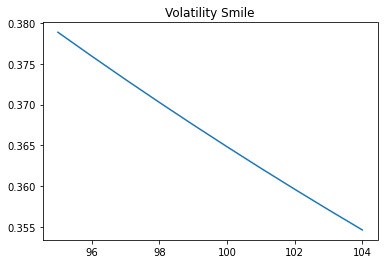

In [36]:
def visualize_heston_param_impact():
    
    strikes = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
    prices = [17.28161603537884, 16.69696133475172, 16.123873269363045, 15.56245174485619, 15.01278676662735, 14.474958096467205, 13.94903492601135, 13.435075569240205, 12.933127176336733, 12.443225471262657]
    impl_vols = []
    
    for i in range(len(strikes)):
        
        impl_vol = NewtonRaphson(prices[i], S=100, K=strikes[i], T=1)
        impl_vols.append(impl_vol)
        
    smile_df = pd.DataFrame({
    'implied_vol': impl_vols,
    'strike': strikes})
    
    # Produce volatility smiles
    fig1, ax1 = plt.subplots()
    ax1.plot(smile_df['strike'], smile_df['implied_vol'])
    ax1.set_title('Volatility Smile')
        
    return prices

visualize_heston_param_impact()


/Users/berkeaslan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/berkeaslan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/Users/berkeaslan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: nan
- Number of iteration: 101
- Tolerance: 0.0001
        ------------------------        
        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.036716647006912434
- Number of iteration: 6
- Tolerance: 0.0001
        ------------------------        
        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.04155106960545703
- Number of iteration: 5
- Tolerance: 0.0001
        ------------------------        
        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.03866823063957675
- Number of iteration: 5
- Tolerance: 0.0001
        ------------------------        
        Newton-Raphson algorithm        
        ------------------------        
- Zero of the function f: 0.02721236291307025
- Number of iteration: 4
- To

[5.075746959583697,
 4.241104927357441,
 3.5525679473666827,
 2.730894874133071,
 1.6529887002062509,
 0.4992459393687625,
 -0.3770420907068228,
 -0.7326489867958301,
 -0.621077457222464,
 -0.33602706637648705]

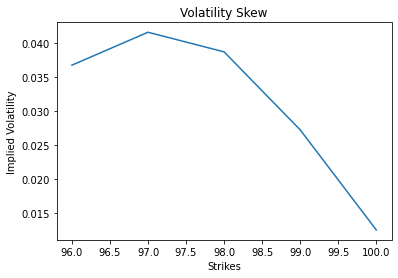

In [113]:
def visualize_heston_param_impact(x):
    
    strikes = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
    prices = []
    impl_vols = []
    
    for strike in strikes:
    
        price = call_price(kappa=x[0], theta=x[1], sigma=x[2], rho=x[3], v0=x[4] ,r=0 ,T=1 ,s0=100 ,K=strike)
        prices.append(price)
        
        impl_vol = NewtonRaphson(price, S=100, K=strike, T=1)
        impl_vols.append(impl_vol)
        
    smile_df = pd.DataFrame({
    'implied_vol': impl_vols,
    'strike': strikes})
    
    # Produce volatility smiles
    fig1, ax1 = plt.subplots()
    ax1.plot(smile_df['strike'], smile_df['implied_vol'])
    ax1.set_title('Volatility Skew')
    ax1.set_ylabel('Implied Volatility')
    ax1.set_xlabel('Strikes')
        
    return prices

    #    kappa        theta         sigma,       rho          v0
x = [ 0.1  ,  0.1,  0.8, -1, 0]

visualize_heston_param_impact(x)

In [120]:
# genetic algorithm search for continuous function optimization
from numpy.random import randint
from numpy.random import rand
 
# decode bitstring to numbers
def decode(bounds, n_bits, bitstring):
    decoded = list()
    largest = 2**n_bits
    for i in range(len(bounds)):
        # extract the substring
        start, end = i * n_bits, (i * n_bits)+n_bits
        substring = bitstring[start:end]
        # convert bitstring to a string of chars
        chars = ''.join([str(s) for s in substring])
        # convert string to integer
        integer = int(chars, 2)
        # scale integer to desired range
        value = bounds[i][0] + (integer/largest) * (bounds[i][1] - bounds[i][0])
        # store
        decoded.append(value)
    return decoded
 
# tournament selection
def selection(pop, scores, k=3):
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]
 
# crossover two parents to create two children
def crossover(p1, p2, r_cross):
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
    # check for recombination
    if rand() < r_cross:
        # select crossover point that is not on the end of the string
        pt = randint(1, len(p1)-2)
        # perform crossover
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    return [c1, c2]
 
# mutation operator
def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        # check for a mutation
        if rand() < r_mut:
            # flip the bit
            bitstring[i] = 1 - bitstring[i]
            
# Genetic Algorithm
def genetic_algorithm(objective, bounds, n_bits, n_iter, n_pop, r_cross, r_mut):
    # initial population of random bitstring
    pop = [randint(0, 2, n_bits*len(bounds)).tolist() for _ in range(n_pop)]
    # keep track of best solution
    best, best_eval = 0, objective(decode(bounds, n_bits, pop[0]))
    # enumerate generations
    for gen in range(n_iter):
        # decode population
        decoded = [decode(bounds, n_bits, p) for p in pop]
        # evaluate all candidates in the population
        scores = [objective(d) for d in decoded]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best, best_eval = pop[i], scores[i]
                print(">%d, new best f(%s) = %f" % (gen,  decoded[i], scores[i]))
        # select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(c)
        # replace population
        pop = children
    return [best, best_eval]
 
# define range for input
bounds = [[0, 10], [0, 5], [0, 1], [0, 0.02], [0, 1]]
# define the total iterations
n_iter = 4
# bits per variable
n_bits = 16
# define the population size
n_pop = 100
# crossover rate
r_cross = 0.9
# mutation rate
r_mut = 1.0 / (float(n_bits) * len(bounds))
# perform the genetic algorithm search
best, score = genetic_algorithm(objective, bounds, n_bits, n_iter, n_pop, r_cross, r_mut)
print('Done!')
decoded = decode(bounds, n_bits, best)
print('f(%s) = %f' % (decoded, score))

>0, new best f([4.98016357421875, 0.771484375, 0.4325103759765625, 0.010003051757812501, 0.0071258544921875]) = 11290.910904
>0, new best f([9.208984375, 0.4084014892578125, 0.358245849609375, 0.011024169921875, 0.320831298828125]) = 7142.939025
>0, new best f([4.954376220703125, 0.1944732666015625, 0.9405364990234375, 0.01475860595703125, 0.22064208984375]) = 2387.935562
>0, new best f([0.038909912109375, 0.9149932861328125, 0.1190338134765625, 0.018712768554687502, 0.1219482421875]) = 1150.970950
>0, new best f([1.21551513671875, 0.10009765625, 0.96539306640625, 0.008287353515625, 0.1130523681640625]) = 419.624211
>1, new best f([3.962249755859375, 0.007781982421875, 0.7835540771484375, 0.00020416259765625, 0.0537261962890625]) = 153.060059
>1, new best f([1.05926513671875, 0.10009765625, 0.96539306640625, 0.0057873535156250005, 0.0506134033203125]) = 58.597403
>2, new best f([0.446624755859375, 0.007781982421875, 0.7835540771484375, 0.00020416259765625, 0.0537261962890625]) = 43.789

In [116]:
x0 = [kappa, theta, sigma, rho, v0]

In [117]:
market_prices = [[12.40, 9.59 ,8.28, 7.40, 6.86, 6.58 ,6.52 ,6.49 ,6.47, 6.46],
                    [11.79, 8.95, 8.07, 7.03, 6.18, 6.04, 5.76, 5.50, 5.50, 5.39],
                    [10.71, 8.28, 6.91, 6.36, 5.29, 5.07, 4.76, 4.47, 4.35, 4.14],
                    [8.67, 7.14, 5.98, 4.93, 4.09, 3.99, 3.43, 3.01, 2.72, 2.53]]

In [118]:
market_prices[1][1]

8.95